In [123]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/interploated_m.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')

target = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in target]

df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-31,6.3,-30.503871,4.964516,-827548.704,2.387097
2009-02-28,14.0,-29.350000,5.125000,-717952.896,2.546429
2009-03-31,34.2,-28.502903,9.254839,-879621.120,2.490323
2009-04-30,16.3,-27.736333,13.806667,-845030.016,2.403333
2009-05-31,28.6,-27.478065,19.809677,-997805.952,2.109677
...,...,...,...,...,...
2020-02-29,18.6,-25.261724,8.989655,-822268.800,2.420690
2020-03-31,70.2,-24.945355,9.758065,-830281.536,2.722581
2020-04-30,41.6,-24.805133,14.016667,-739037.952,2.500000


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

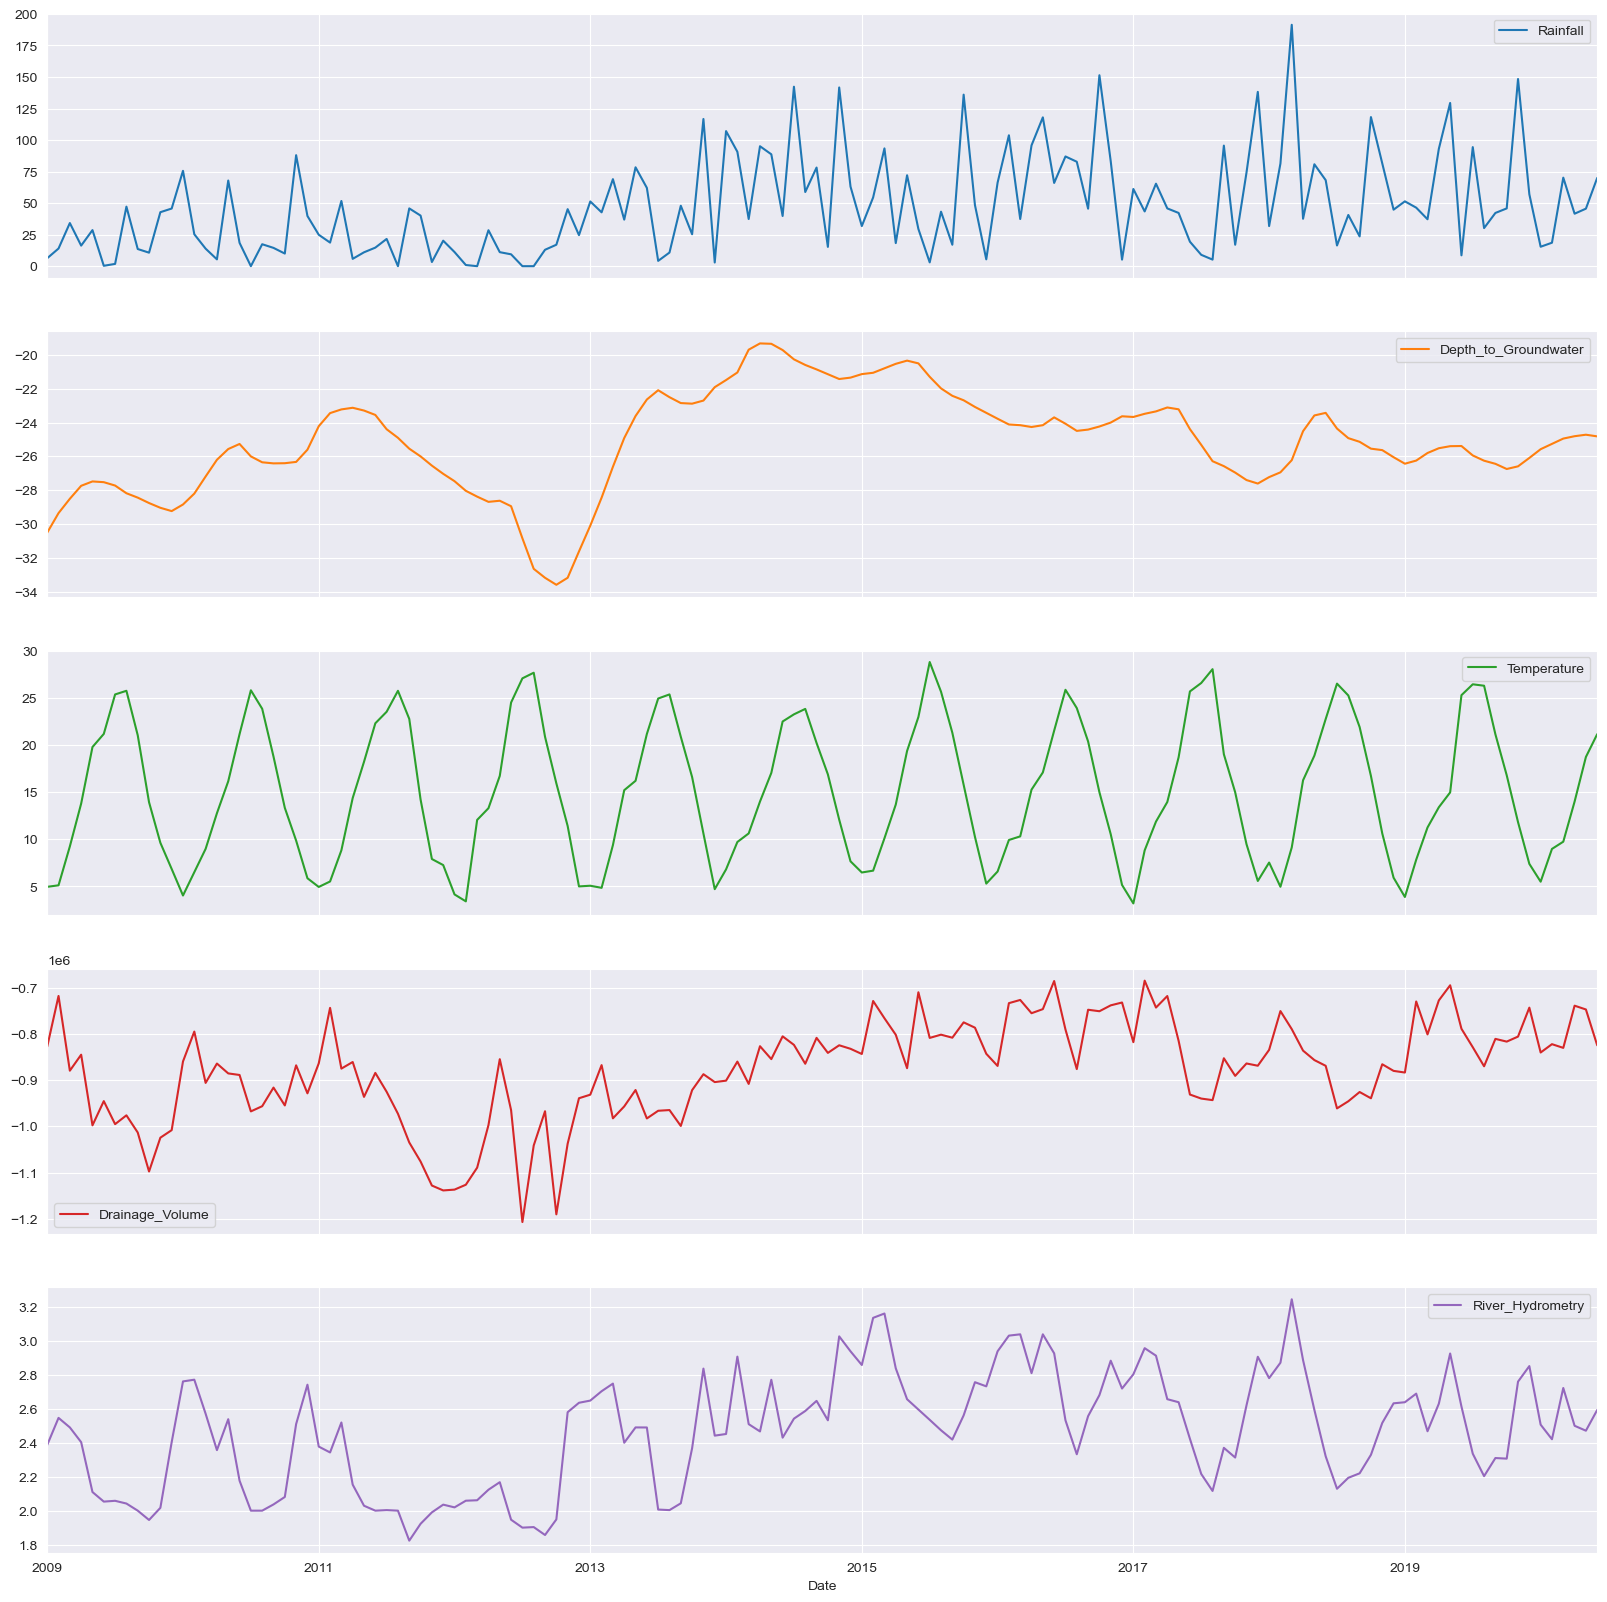

In [124]:
df.plot(subplots=True, figsize=(20, 20))

In [125]:
def split_data():
    testSize = int(0.3 * len(df))
    train= df.iloc[:-testSize]
    test= df.iloc[-testSize:]
    return train, test
train, test = split_data()

In [126]:
testSize = int(0.3 * len(df))
testSize

41

In [127]:
# Find the optimal ARIMAX model order using auto_arima
auto_model = auto_arima(
    train[target],
    exogenous=train[features],
    seasonal=True,  # Set to True for seasonal data
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    max_order=None,  # You can limit the search space for orders
    trace=True
)

# Get the selected order
order = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=200.969, Time=0.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108.405, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=124.250, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=200.032, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=101.623, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=103.569, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=101.942, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=100.478, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=101.750, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=113.076, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=98.807, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=123.054, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=106.699, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=100.383, T

In [128]:
def fit_arimax(df):
    model = ARIMA(endog=df[target], exog=df[features], order=order)
    model=model.fit()
    return model

In [129]:
model = fit_arimax(train)
predictions = model.predict(start=test.index[0], end=test.index[-1], exog=test[features])

<Axes: xlabel='Date'>

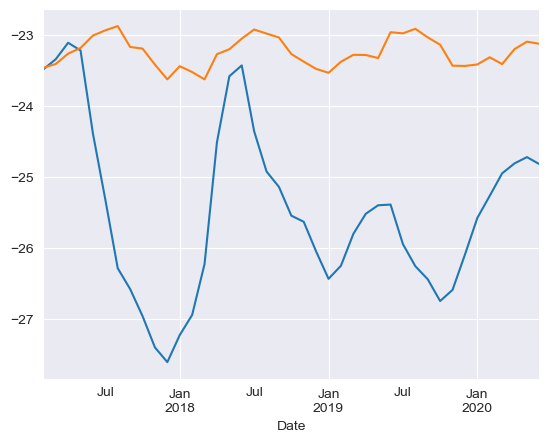

In [130]:

test['Depth_to_Groundwater'].plot()
predictions.plot()

In [131]:
# Rolling ARIMA algorithm
def arimax_roll():
    history = train.copy()
    predictions = pd.Series()

    for t in range(len(test)):
        model = fit_arimax(history)
        hat = model.forecast(steps=1, exog=history[features].iloc[[-1]])  # Forecast one step ahead
        predictions = predictions.append(hat)

        # Update history and exogenous history for the next iteration
        history = history.append(test.iloc[t])
    return predictions

In [132]:
predictions = arimax_roll()

In [133]:
predictions

2017-02-28   -23.633394
2017-03-31   -23.468324
2017-04-30   -23.239595
2017-05-31   -23.037092
2017-06-30   -23.392429
2017-07-31   -25.521495
2017-08-31   -25.961329
2017-09-30   -27.056851
2017-10-31   -26.470332
2017-11-30   -27.281216
2017-12-31   -27.554875
2018-01-31   -27.597136
2018-02-28   -27.047374
2018-03-31   -26.676860
2018-04-30   -25.619499
2018-05-31   -23.491396
2018-06-30   -23.002943
2018-07-31   -23.545148
2018-08-31   -25.258480
2018-09-30   -25.162528
2018-10-31   -25.214807
2018-11-30   -25.645060
2018-12-31   -25.581807
2019-01-31   -26.317037
2019-02-28   -26.646985
2019-03-31   -26.212942
2019-04-30   -25.498138
2019-05-31   -25.360315
2019-06-30   -25.310795
2019-07-31   -25.730683
2019-08-31   -26.303879
2019-09-30   -26.481931
2019-10-31   -26.426504
2019-11-30   -26.897827
2019-12-31   -26.175253
2020-01-31   -25.758993
2020-02-29   -25.174808
2020-03-31   -25.176384
2020-04-30   -24.630636
2020-05-31   -24.937075
2020-06-30   -24.716325
Freq: M, dtype: 

<Axes: xlabel='Date'>

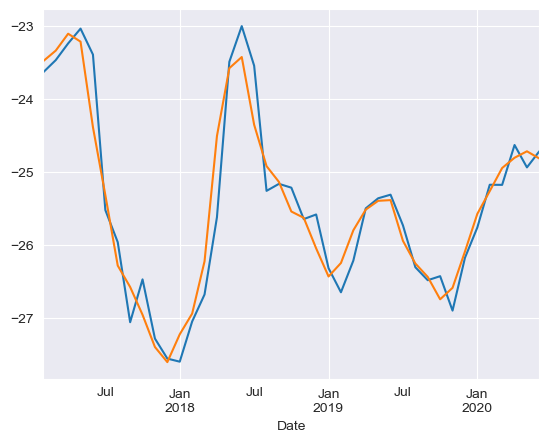

In [134]:
predictions.plot()
test['Depth_to_Groundwater'].plot()

In [135]:
predictions.name = 'Depth_to_Groundwater'
predictions.to_csv('predictions/ARIMAX/3.csv')

In [147]:
saved_sr = pd.read_csv('./predictions/ARIMA/7.csv', index_col=0)
saved_sr.index = pd.to_datetime(saved_sr.index, format = '%Y-%m-%d')

In [136]:
saved_sr = predictions

In [137]:
metrics = {}
def calc_metrics():

    results = pd.DataFrame(data={'Predictions':saved_sr, 'Actuals':df['Depth_to_Groundwater']}, index=saved_sr.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

rmse, mae, mape = calc_metrics()
metrics['Depth_to_Groundwater'] = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('metrics/ARIMAX/3.csv')

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

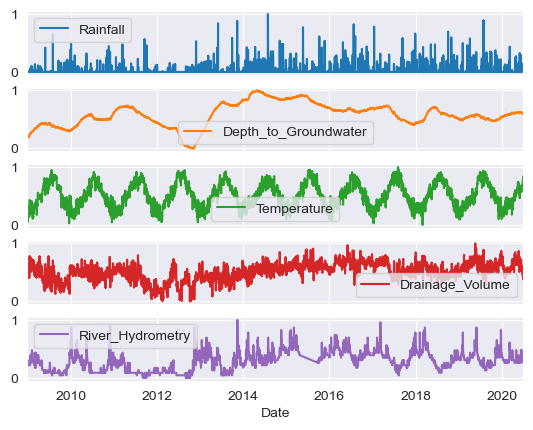

In [50]:
df.plot(subplots=True)